/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 1.0474, Val Loss: 1.1230, Train Accuracy: 0.4262, Test Accuracy: 0.3654
Epoch 2/50, Loss: 1.0258, Val Loss: 1.1362, Train Accuracy: 0.4334, Test Accuracy: 0.3654
Epoch 3/50, Loss: 1.0014, Val Loss: 0.9463, Train Accuracy: 0.3995, Test Accuracy: 0.3654
Epoch 4/50, Loss: 0.8828, Val Loss: 0.9691, Train Accuracy: 0.5157, Test Accuracy: 0.5096
Epoch 5/50, Loss: 0.8238, Val Loss: 0.6652, Train Accuracy: 0.4697, Test Accuracy: 0.5481
Epoch 6/50, Loss: 0.7751, Val Loss: 1.0686, Train Accuracy: 0.5327, Test Accuracy: 0.5769
Epoch 7/50, Loss: 0.7150, Val Loss: 0.6225, Train Accuracy: 0.5714, Test Accuracy: 0.5673
Epoch 8/50, Loss: 0.6737, Val Loss: 0.6075, Train Accuracy: 0.6005, Test Accuracy: 0.6538
Epoch 9/50, Loss: 0.7144, Val Loss: 0.6352, Train Accuracy: 0.5884, Test Accuracy: 0.5962
Epoch 10/50, Loss: 0.6792, Val Loss: 0.5899, Train Accuracy: 0.6077, Test Accuracy: 0.6731
Epoch 11/50, Loss: 0.6748, Val Loss: 0.6511, Train Accuracy: 0.6029, Test Accuracy: 0.7308
Epoch 12

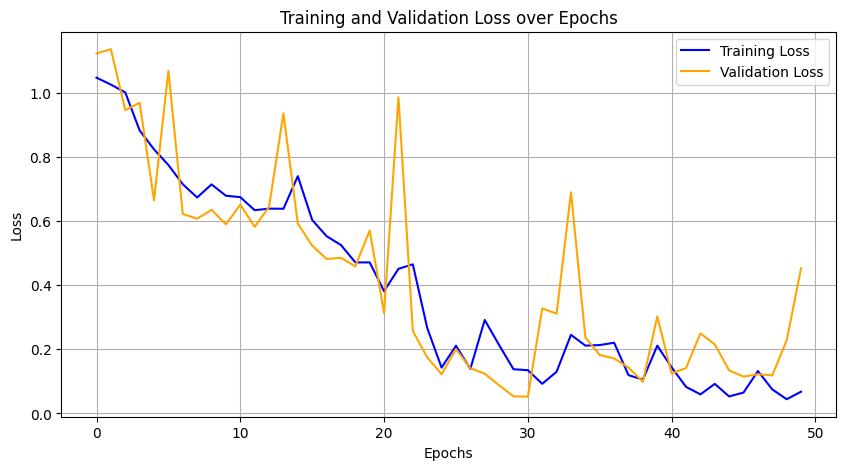

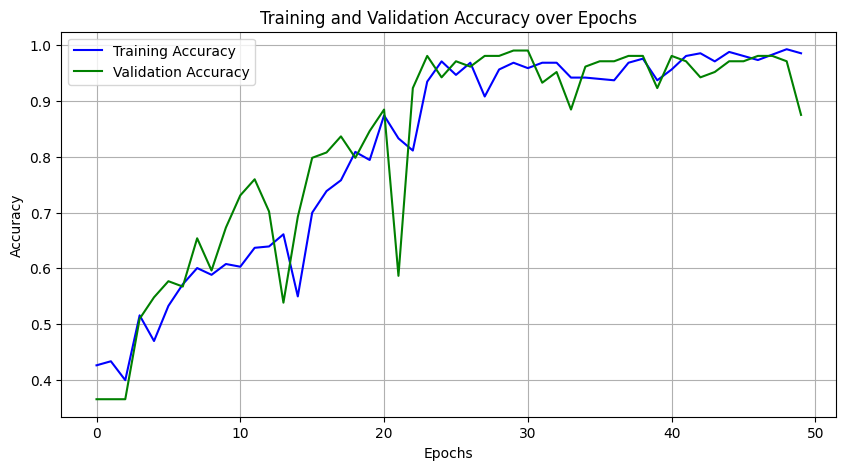

Results saved to /content/drive/MyDrive/Colab Notebooks/piping_database/labeled_data_results_with_minimal_features.csv
              precision    recall  f1-score   support

      Normal       0.81      1.00      0.89        38
     NoQueen       1.00      0.79      0.88        43
       Swarm       0.96      0.96      0.96        23

    accuracy                           0.90       104
   macro avg       0.92      0.92      0.91       104
weighted avg       0.92      0.90      0.90       104



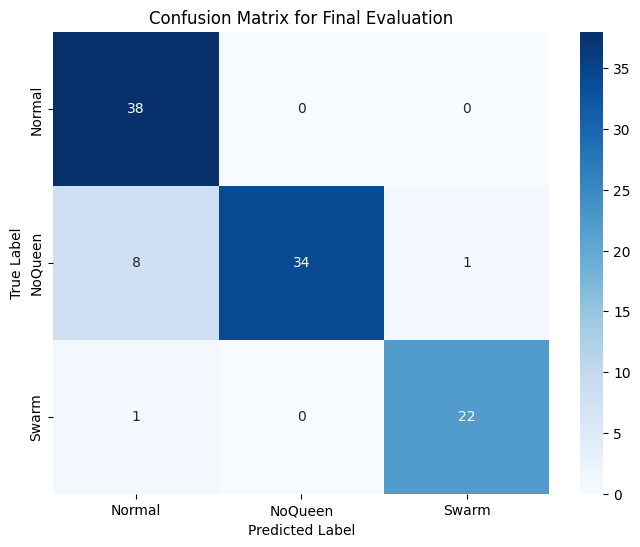

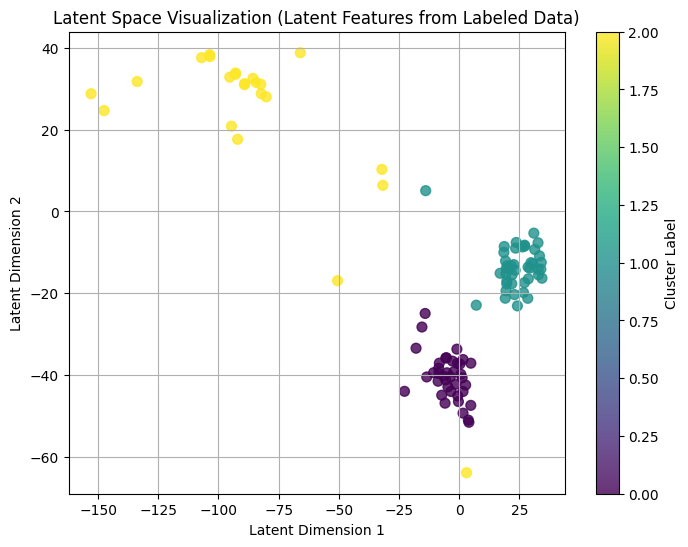

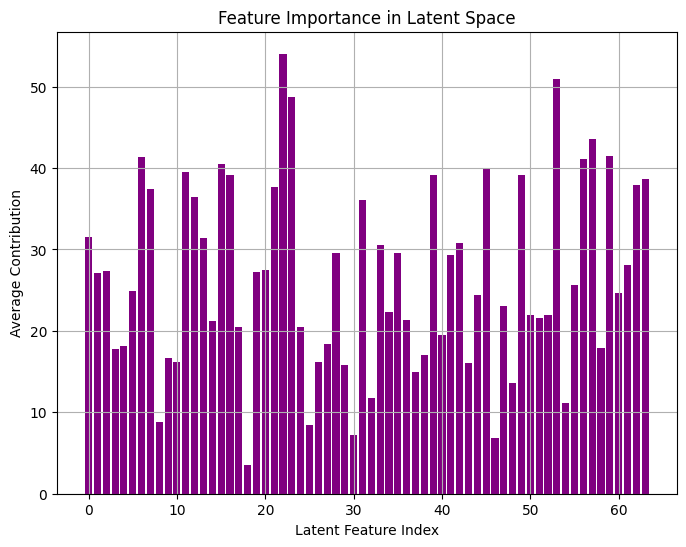

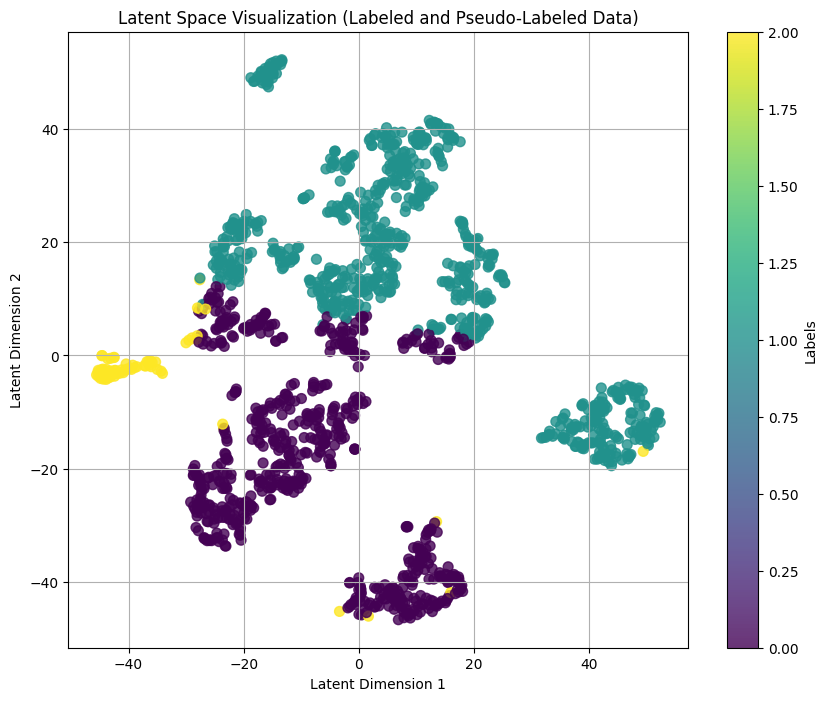

Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: NoQueen | Nearest Labeled Neighbor: NoQueen
Pseudo-Label: 

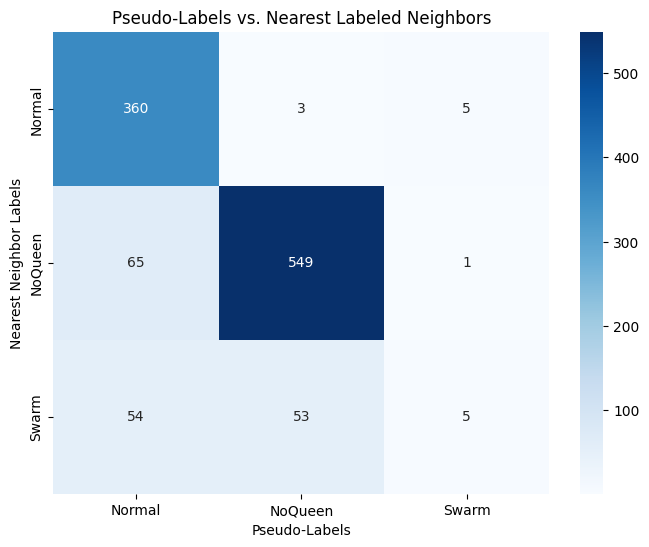

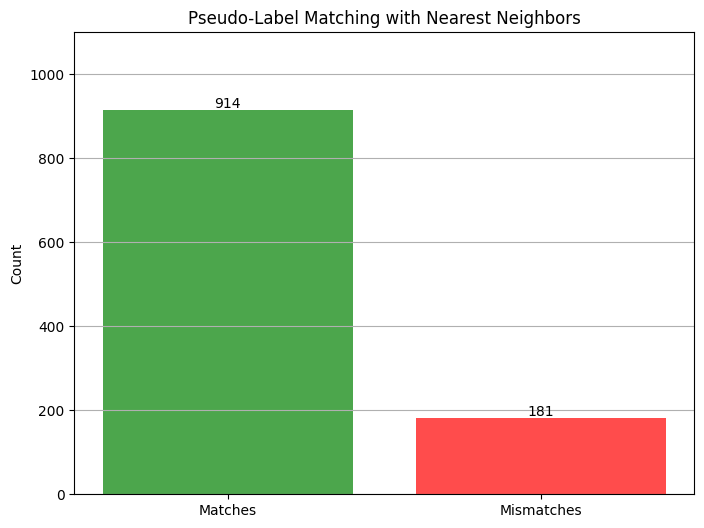

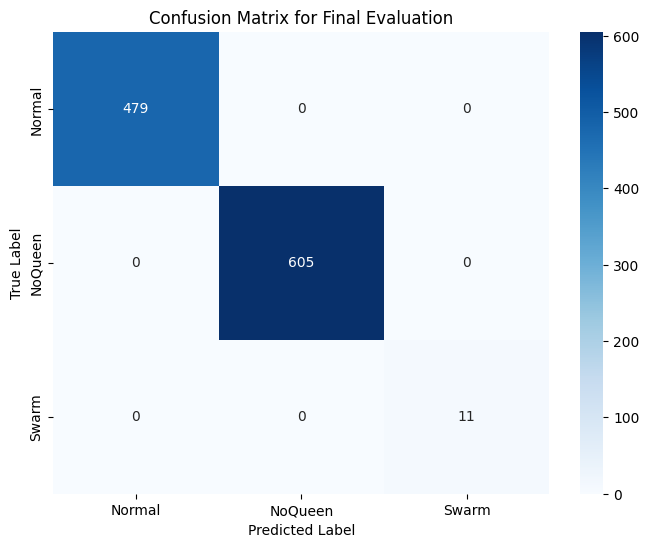

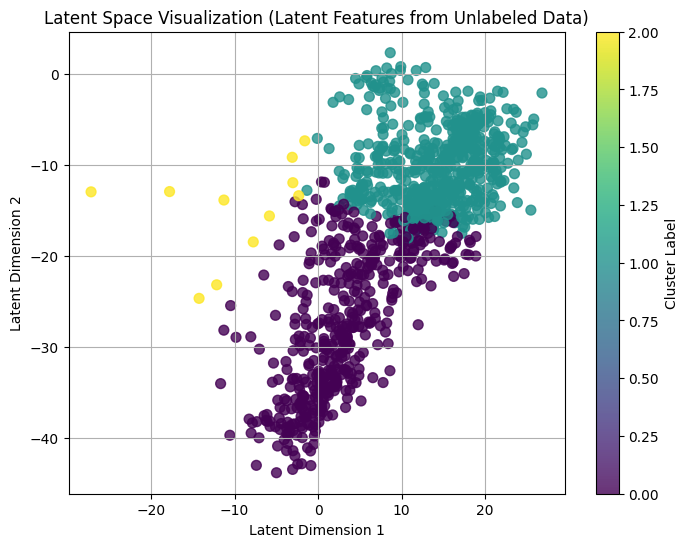

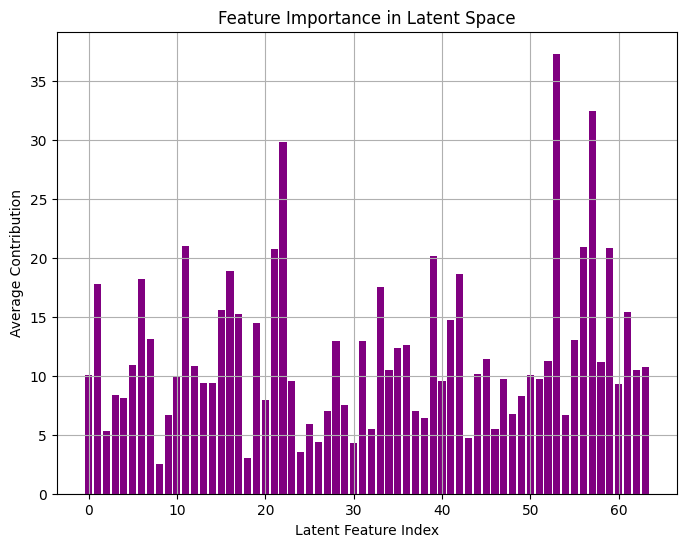

Silhouette Score: 0.4095
Davies-Bouldin Index: 0.8898


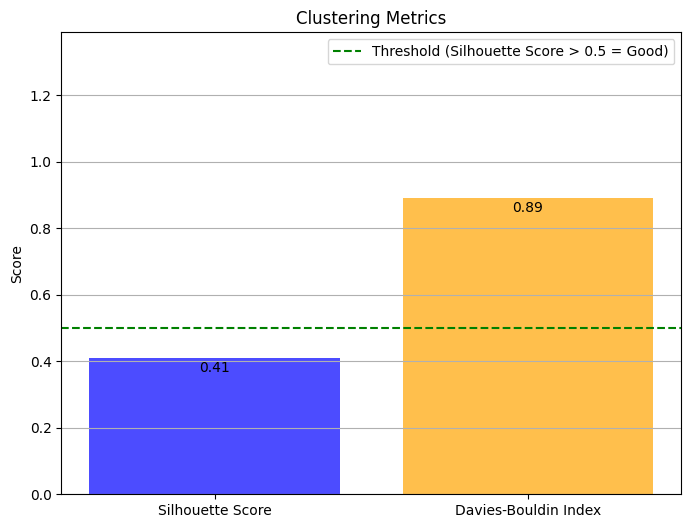

Unlabeled data results saved to /content/drive/MyDrive/Colab Notebooks/piping_database/unlabeled_data_results_with_minimal_features.csv


In [6]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report



# Label mapping
label_mapping = {
    0: ("Normal", "Not Stressed"),
    1: ("NoQueen", "Stressed"),
    2: ("Swarm", "Stressed"),
}

# Function to load audio data and labels
def load_audio_data(label_dir):
    audio_files = []
    labels = []
    for root, dirs, files in os.walk(label_dir):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label_name = os.path.basename(root)
                for label_int, (name, _) in label_mapping.items():
                    if name == label_name:
                        label = label_int
                        break
                else:
                    raise ValueError(f"Unknown label directory: {label_name}")
                audio_files.append(file_path)
                #print(f"file : {file_path}")
                labels.append(label)
    return audio_files, labels

# Function to extract MFCC features along with additional features
def extract_features_with_minimal_factors(audio_files):
    features = []
    for file in audio_files:
        try:
            y, sr = librosa.load(file, sr=None)

            # MFCCs
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfcc = np.mean(mfcc.T, axis=0)  # Shape: (40,)

            delta_mfcc = librosa.feature.delta(mfcc)
            delta2_mfcc = librosa.feature.delta(mfcc, order=2)
            # RMS
            rms = librosa.feature.rms(y=y).mean()

            # Spectral Centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

            # Dominant Frequency (STFT)
            stft = np.abs(librosa.stft(y))
            frequencies = librosa.fft_frequencies(sr=sr)
            dominant_frequency = frequencies[np.argmax(np.sum(stft, axis=1))]

            # Combine all features into a 1D array
            feature_vector = np.concatenate([mfcc, delta_mfcc, delta2_mfcc, [rms, spectral_centroid, dominant_frequency]])

            features.append(feature_vector)

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

    return np.array(features)



# Function to create data loaders
def create_dataloaders(features, labels, batch_size=16):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long) if labels is not None else None
    dataset = TensorDataset(features_tensor, labels_tensor) if labels is not None else TensorDataset(features_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the autoencoder-transformer model
def create_model(input_dim, num_classes):
    class AutoencoderTransformer(nn.Module):
        def __init__(self):
            super(AutoencoderTransformer, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
            )
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=64, nhead=4), num_layers=2
            )
            self.decoder = nn.Sequential(
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes),
            )

        def forward(self, x):
            x = self.encoder(x)
            x = x.unsqueeze(0).permute(1, 0, 2)  # Add batch and sequence dimensions
            x = self.transformer(x).squeeze(1)  # Remove sequence dimension
            x = self.decoder(x)
            return x

    return AutoencoderTransformer()
# Plot Training and Validation Metrics
# Corrected plot_training_metrics function
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Confusion Matrix
def plot_confusion_matrix_final(all_labels, all_preds, label_mapping):
    cm = confusion_matrix(all_labels, all_preds)
    labels = [v[0] for v in label_mapping.values()]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Final Evaluation')
    plt.show()


# Plot Classification Report (Bar Chart)
def plot_classification_report(all_labels, all_preds, label_mapping):
    report = classification_report(all_labels, all_preds, target_names=[v[0] for v in label_mapping.values()], output_dict=True)
    classes = list(report.keys())[:-3]  # Ignore 'accuracy', 'macro avg', 'weighted avg'
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1_score = [report[cls]['f1-score'] for cls in classes]

    # Bar plot for Precision, Recall, and F1-Score
    bar_width = 0.25
    x = np.arange(len(classes))

    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width, precision, bar_width, label='Precision', color='blue')
    plt.bar(x, recall, bar_width, label='Recall', color='green')
    plt.bar(x + bar_width, f1_score, bar_width, label='F1-Score', color='orange')
    plt.xticks(x, classes, rotation=45)
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score per Class')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

def visualize_latent_space(latent_features, labels, method_name="Transformer-based Autoencoder"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f"Latent Space Visualization ({method_name})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

def extract_and_display_latent_features(model, dataloader, label_mapping):
    model.eval()
    latent_features = []
    labels = []

    with torch.no_grad():
        for features, batch_labels in dataloader:
            # Extract latent features using the encoder
            encoded_features = model.encoder(features)
            latent_features.extend(encoded_features.numpy())
            labels.extend(batch_labels.numpy())

    # Convert to NumPy arrays
    latent_features = np.array(latent_features)
    labels = np.array(labels)

    # Display some of the latent features
    #print("Sample Latent Features:")
    #print(latent_features[:5])  # Display the first 5 latent feature vectors

    # Visualize Latent Space
    visualize_latent_space(latent_features, labels, method_name="Latent Features from Labeled Data")
    feature_importance_Graph(latent_features)

# Feature Importance Graph
def feature_importance_Graph(latent_features):
    feature_importance = np.mean(np.abs(latent_features), axis=0)

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(feature_importance)), feature_importance, color='purple')
    plt.xlabel("Latent Feature Index")
    plt.ylabel("Average Contribution")
    plt.title("Feature Importance in Latent Space")
    plt.grid(True)
    plt.show()

# Function to visualize latent space
def visualize_labeled_and_pseudo_labeled_latent_space(labeled_latent, labeled_labels, pseudo_latent, pseudo_labels):
    # Combine labeled and pseudo-labeled data
    combined_latent = np.vstack([labeled_latent, pseudo_latent])
    combined_labels = np.hstack([labeled_labels, pseudo_labels])
    label_types = np.array(["Labeled"] * len(labeled_labels) + ["Pseudo-Labeled"] * len(pseudo_labels))

    # Perform t-SNE for 2D projection
    tsne = TSNE(n_components=2, random_state=42)
    reduced_latent = tsne.fit_transform(combined_latent)

    # Plot labeled and pseudo-labeled data
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=combined_labels,
        cmap="viridis",
        s=50,
        alpha=0.8,
        label=label_types
    )
    plt.colorbar(scatter, label="Labels")
    plt.title("Latent Space Visualization (Labeled and Pseudo-Labeled Data)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()


# Function to compare pseudo-labels to nearest labeled samples
def compare_pseudo_labels_with_neighbors(labeled_latent, labeled_labels, pseudo_latent, pseudo_labels):
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(pseudo_latent, labeled_latent)

    # Find the nearest labeled neighbor for each pseudo-labeled sample
    nearest_neighbors = np.argmax(similarity_matrix, axis=1)

    # Compare pseudo-labels with nearest labeled neighbors
    matches = 0
    for i, neighbor_idx in enumerate(nearest_neighbors):
        pseudo_label = pseudo_labels[i]
        nearest_label = labeled_labels[neighbor_idx]
        if pseudo_label == nearest_label:
            matches += 1
        print(f"Pseudo-Label: {label_mapping[pseudo_label][0]} | Nearest Labeled Neighbor: {label_mapping[nearest_label][0]}")

    # Accuracy of pseudo-labeling based on nearest neighbors
    accuracy = matches / len(pseudo_labels)
    print(f"Accuracy of Pseudo-Labels based on Nearest Neighbors: {accuracy:.2f}")

    return accuracy
# Function to evaluate the model and save results to CSV
def evaluate_model_and_save_labels(model, dataloader, audio_files, save_csv_path):
    model.eval()
    all_preds = []
    all_labels = []
    results = []
    with torch.no_grad():
        for features, labels in dataloader:
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
            for i in range(len(labels)):
                # Extract subfolder name and file name
                file_path = audio_files[i]
                subfolder_name = os.path.basename(os.path.dirname(file_path))  # Extract the subfolder name
                file_name = os.path.basename(file_path)  # Extract the file name

                # Add results with subfolder and file name
                results.append({
                    "subfolder_name": subfolder_name,
                    "file_name": file_name,
                    "true_label": label_mapping[labels[i].item()][0],
                    "predicted_label": label_mapping[preds[i].item()][0],
                    "is_stressed": label_mapping[preds[i].item()][1],  # Stressed or Not Stressed
                })

    # Save results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(save_csv_path, index=False)
    print(f"Results saved to {save_csv_path}")

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=[v[0] for v in label_mapping.values()]))



    # Visualize confusion matrix
    plot_confusion_matrix_final(all_labels, all_preds, label_mapping)

    # Visualize classification report
   # plot_classification_report(all_labels, all_preds, label_mapping)




# Plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds, label_mapping):
    cm = confusion_matrix(all_labels, all_preds)
    labels = [v[0] for v in label_mapping.values()]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to train the model
def train_model_with_tracking(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for features, labels in test_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                preds = torch.argmax(outputs, dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        val_loss = val_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        val_losses.append(val_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, test_accuracies

# Load labeled data
label_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database/LabelDataUsed/"
audio_files, labels = load_audio_data(label_dir)
features = extract_features_with_minimal_factors(audio_files)

# Split data and create data loaders
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
train_loader = create_dataloaders(train_features, train_labels)
test_loader = create_dataloaders(test_features, test_labels)

# Create model, define loss, and optimizer
input_dim = features.shape[1]  # Update input_dim based on new feature size
num_classes = len(label_mapping)
model = create_model(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model and track losses/accuracies
train_losses, val_losses, train_accuracies, test_accuracies = train_model_with_tracking(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=50
)
########################################
# Step 2: Generate predictions for the test set
true_labels = []
predicted_labels = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for features, labels in test_loader:  # Use the labeled test loader
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class
        true_labels.extend(labels.numpy())  # Add true labels to the list
        predicted_labels.extend(preds.numpy())  # Add predictions to the list

# Step 3: Generate the classification report
from sklearn.metrics import classification_report

# Create and print the classification report
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=[v[0] for v in label_mapping.values()]  # Use class names from label_mapping
)
print("Classification Report:")
print(report)
#######################################
# Plot the metrics
plot_training_metrics(train_losses, val_losses, train_accuracies, test_accuracies)

# Evaluate the model and save results to CSV
evaluate_model_and_save_labels(model, test_loader, audio_files, save_csv_path="/content/drive/MyDrive/Colab Notebooks/piping_database/labeled_data_results_with_minimal_features.csv")
extract_and_display_latent_features(model, test_loader, label_mapping)
######################
# Visualize Silhouette Score and Davies-Bouldin Index
def plot_clustering_scores(silhouette_avg, davies_bouldin_avg):
    scores = [silhouette_avg, davies_bouldin_avg]
    labels = ['Silhouette Score', 'Davies-Bouldin Index']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, scores, color=['blue', 'orange'], alpha=0.7)
    plt.title("Clustering Metrics")
    plt.ylabel("Score")
    plt.ylim(0, max(scores) + 0.5)

    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height - 0.05, f'{height:.2f}', ha='center', va='bottom')

    plt.axhline(y=0.5, color='green', linestyle='--', label="Threshold (Silhouette Score > 0.5 = Good)")
    plt.legend()
    plt.grid(axis='y')
    plt.show()

def plot_pseudo_vs_neighbors_confusion_matrix(pseudo_labels, nearest_labels, label_mapping):
    cm = confusion_matrix(nearest_labels, pseudo_labels)
    labels = [v[0] for v in label_mapping.values()]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Pseudo-Labels")
    plt.ylabel("Nearest Neighbor Labels")
    plt.title("Pseudo-Labels vs. Nearest Labeled Neighbors")
    plt.show()

def plot_pseudo_label_match_percentage(pseudo_labels, nearest_labels):
    matches = np.sum(pseudo_labels == nearest_labels)
    mismatches = len(pseudo_labels) - matches

    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Matches', 'Mismatches'], [matches, mismatches], color=['green', 'red'], alpha=0.7)
    plt.title("Pseudo-Label Matching with Nearest Neighbors")
    plt.ylabel("Count")
    plt.ylim(0, len(pseudo_labels) + 5)

    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height - 1, f'{height}', ha='center', va='bottom')

    plt.grid(axis='y')
    plt.show()
######################
def extract_and_display_latent_features_unlabeled(model, unlabeled_features, pseudo_labels):
    model.eval()
    latent_features = []

    with torch.no_grad():
        for i in range(len(unlabeled_features)):
            # Extract latent features for each file
            feature_tensor = torch.tensor(unlabeled_features[i:i+1], dtype=torch.float32)
            encoded_features = model.encoder(feature_tensor)
            latent_features.append(encoded_features.numpy())

    # Convert to NumPy array
    latent_features = np.vstack(latent_features)

    # Visualize Latent Space
    visualize_latent_space(latent_features, pseudo_labels, method_name="Latent Features from Unlabeled Data")
    feature_importance_Graph(latent_features)

    return latent_features



# Process unlabeled data
unlabeled_dir = "/content/drive/MyDrive/Colab Notebooks/piping_database/FinalDataSet/"
unlabeled_files = [os.path.join(unlabeled_dir, f) for f in os.listdir(unlabeled_dir) if f.endswith(".wav")]
unlabeled_features = extract_features_with_minimal_factors(unlabeled_files)

# Generate pseudo-labels for unlabeled data
with torch.no_grad():
    outputs = model(torch.tensor(unlabeled_features, dtype=torch.float32))
    pseudo_labels = torch.argmax(outputs, dim=1).numpy()
    #print("Unique Pseudo-Labels:", np.unique(pseudo_labels))
    #################################################
    # Extract latent features for labeled data
    labeled_latent_features = []
    labeled_labels = []
    model.eval()
    with torch.no_grad():
        for features, labels in train_loader:  # Use labeled data loader
            encoded_features = model.encoder(features)
            labeled_latent_features.extend(encoded_features.numpy())
            labeled_labels.extend(labels.numpy())

    # Extract latent features for pseudo-labeled data
    pseudo_latent_features = []
    with torch.no_grad():
        for features in torch.tensor(unlabeled_features, dtype=torch.float32):  # Use unlabeled features
            encoded_features = model.encoder(features.unsqueeze(0))
            pseudo_latent_features.append(encoded_features.numpy())

    # Convert to NumPy arrays
    labeled_latent_features = np.array(labeled_latent_features)
    pseudo_latent_features = np.vstack(pseudo_latent_features)

    # Visualize latent space
    visualize_labeled_and_pseudo_labeled_latent_space(
        labeled_latent_features,
        np.array(labeled_labels),
        pseudo_latent_features,
        pseudo_labels
    )

    # Compare pseudo-labels with nearest neighbors
    accuracy = compare_pseudo_labels_with_neighbors(
        labeled_latent_features,
        np.array(labeled_labels),
        pseudo_latent_features,
        pseudo_labels
    )

    # Find nearest labeled neighbors for pseudo-labeled samples
    similarity_matrix = cosine_similarity(pseudo_latent_features, labeled_latent_features)
    nearest_neighbors = np.argmax(similarity_matrix, axis=1)
    nearest_labeled_labels = [labeled_labels[idx] for idx in nearest_neighbors]

    # Step 4: Visualize pseudo-labels vs nearest labeled neighbors
    plot_pseudo_vs_neighbors_confusion_matrix(pseudo_labels, nearest_labeled_labels, label_mapping)
    #################################################################
    # Step 5: Visualize pseudo-label match percentage
    plot_pseudo_label_match_percentage(pseudo_labels, nearest_labeled_labels)

# Visualize Confusion Matrix for Pseudo-Labels
plot_confusion_matrix_final(pseudo_labels, pseudo_labels, label_mapping)

# Visualize Classification Report for Pseudo-Labels (Bar Chart)
#plot_classification_report(pseudo_labels, pseudo_labels, label_mapping)
latent_features = extract_and_display_latent_features_unlabeled(model, unlabeled_features, pseudo_labels)
# Compute Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(latent_features, pseudo_labels)
davies_bouldin_avg = davies_bouldin_score(latent_features, pseudo_labels)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg:.4f}")
plot_clustering_scores(silhouette_avg, davies_bouldin_avg)


# Analyze predictions for unlabeled data and save to CSV
def process_unlabeled_data_and_save_results(model, unlabeled_files, pseudo_labels, save_csv_path):
    results = []
    for file, predicted_label in zip(unlabeled_files, pseudo_labels):
        results.append({
            "file_name": os.path.basename(file),
            "predicted_label": label_mapping[predicted_label][0],
            "is_stressed": label_mapping[predicted_label][1],
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv(save_csv_path, index=False)
    print(f"Unlabeled data results saved to {save_csv_path}")

process_unlabeled_data_and_save_results(model, unlabeled_files, pseudo_labels, save_csv_path="/content/drive/MyDrive/Colab Notebooks/piping_database/unlabeled_data_results_with_minimal_features.csv")
